# Evaluating a Classifier with FiftyOne

This notebook demonstrates an end-to-end example of fine-tuning a classification model [using fastai](https://github.com/fastai/fastai) on a [Kaggle dataset](https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria) and using FiftyOne to evaluate it and understand the strengths and weaknesses of both the model and the underlying ground truth annotations.

Specifically, we'll cover:

- Downloading the dataset via the [Kaggle API](https://github.com/Kaggle/kaggle-api)
- Loading the dataset [into FiftyOne](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html)
- Indexing the dataset by uniqueness using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness) to identify interesting visual characteristics
- Fine-tuning a model on the dataset [using fastai](https://github.com/fastai/fastai)
- [Evaluating](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) the fine-tuned model using FiftyOne
- [Exporting](https://voxel51.com/docs/fiftyone/user_guide/export_datasets.html) the FiftyOne dataset for offline analysis

**So, what's the takeaway?**

The loss function of your model training loop alone doesn't give you the full picture of a model. In practice, the limiting factor on your model's performance is often data quality issues that FiftyOne can help you address. In this notebook, we'll cover:

- Viewing the *most unique* incorrect samples using FiftyOne's [uniqueness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#image-uniqueness)
- Viewing the *hardest* incorrect predictions using FiftyOne's [hardness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness)
- Identifying ground truth *mistakes* using FiftyOne's [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes)

Running the workflow presented here on your ML projects will help you to understand the current failure modes (edge cases) of your model and how to fix them, including:

- Identifying scenarios that require additional training samples in order to boost your model's performance
- Deciding whether your ground truth annotations have errors/weaknesses that need to be corrected before any subsequent model training will be profitable

## Setup

If you haven't already, install FiftyOne:

In [ ]:
%pip install fiftyone

## Load dataset into FiftyOne

Let's load the dataset into [FiftyOne](https://voxel51.com/docs/fiftyone) and explore it!

In [6]:
import fiftyone as fo

DATASET_DIR = "./datasets/cell_images/"

### Create FiftyOne dataset

FiftyOne provides builtin support for loading datasets in [dozens of common formats](https://voxel51.com/docs/fiftyone/user_guide/dataset_creation/index.html) with a single line of code:

In [7]:
# Create FiftyOne dataset
dataset = fo.Dataset.from_dir(
    DATASET_DIR,
    fo.types.ImageClassificationDirectoryTree,
    name="malaria-cell-images",
)
dataset.persistent = True

print(dataset)

 100% |█████████████| 27558/27558 [10.2s elapsed, 0s remaining, 2.7K samples/s]      
Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


### Visualize dataset in the App

Now let's launch the [FiftyOne App](https://voxel51.com/docs/fiftyone/user_guide/app.html) and use it to interactively explore the dataset.

For example, try using the [view bar](https://voxel51.com/docs/fiftyone/user_guide/app.html#using-the-view-bar) to sort the samples so that we can view the *most visually unique* samples in the dataset:


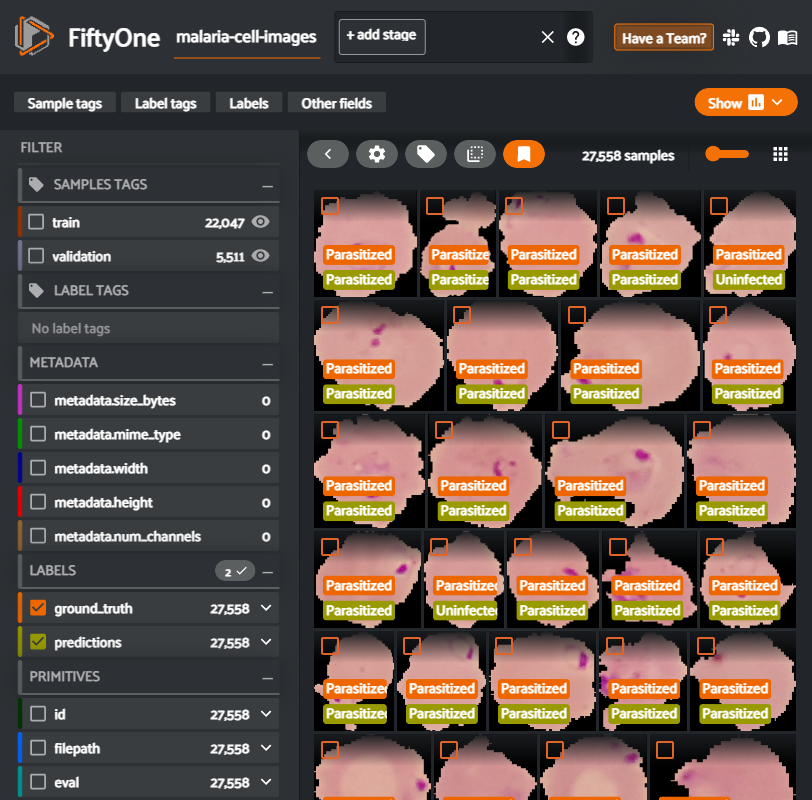

In [42]:
# Most of the MOST UNIQUE samples are parasitized
session = fo.launch_app(dataset)

In [41]:
session

Dataset:     -
Session URL: http://localhost:5151/

## Training a model

Now that we have some basic intuition about the dataset, let's train a model!

In this example, we'll use [fastai](https://github.com/fastai) to fine-tune a pre-trained model on our dataset in just a few lines of code and a few minutes of GPU time.

In [9]:
import numpy as np
from fastai.data.all import *
from fastai.vision.data import *
from fastai.vision.all import *

The code sample below loads the dataset into a fastai data loader:

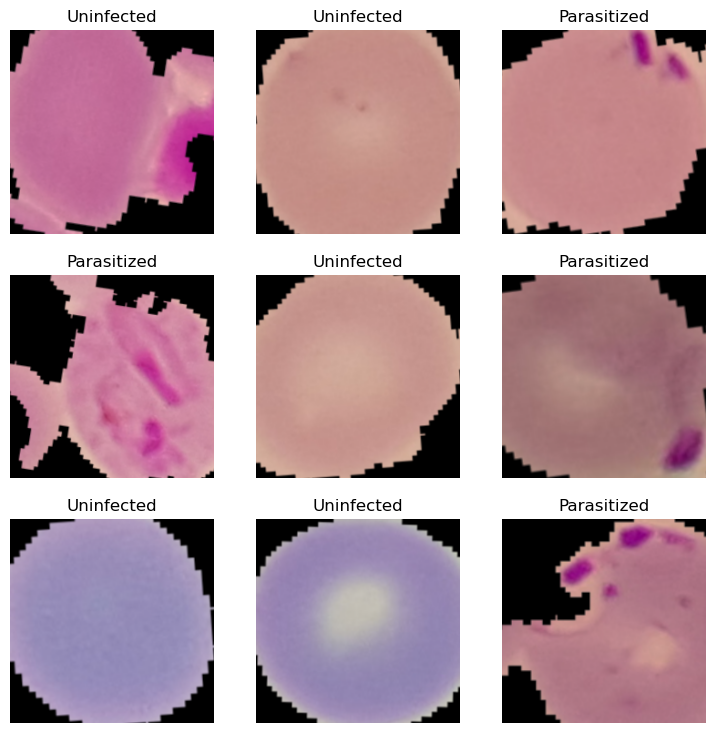

In [10]:
# Load dataset into fastai

path = Path(DATASET_DIR)

splitter = RandomSplitter(valid_pct=0.2)

item_tfms = [Resize(224)]

batch_tfms = [
    *aug_transforms(flip_vert=True, max_zoom=1.2, max_warp=0),
    Normalize.from_stats(*imagenet_stats),
]

data_block = DataBlock(
    blocks=[ImageBlock, CategoryBlock],
    get_items=get_image_files,
    get_y=parent_label,
    splitter=splitter,
    item_tfms=item_tfms,
    batch_tfms=batch_tfms,
)

data = data_block.dataloaders(path, bs=64)
data.show_batch()

Now let's load a pre-trained [xresnet34 model](https://docs.fast.ai/vision.models.xresnet.html):

In [11]:
# Load a pre-trained model
learner = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()

d:\ProgramData\miniconda3\envs\torch\lib\site-packages\fastai\vision\learner.py:288: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")
Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to C:\Users\bruno/.cache\torch\hub\checkpoints\xrn50_940.pth


  0%|          | 0.00/244M [00:00<?, ?B/s]

and fine-tune it for 15 epochs on our dataset:

In [12]:
# Fine-tune model on our dataset
learner.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,0.396216,0.294298,0.885320,06:47


epoch,train_loss,valid_loss,accuracy,time
0,0.245933,0.189301,0.930684,01:41
1,0.205991,0.162619,0.941934,01:38
2,0.186132,0.168503,0.941027,01:38
3,0.171918,0.149666,0.948104,01:39
4,0.168618,0.133991,0.952096,01:39
5,0.163214,0.133041,0.953547,01:39
6,0.145005,0.132418,0.957177,01:39
7,0.146314,0.122027,0.957721,01:39
8,0.138560,0.117939,0.957177,01:39
9,0.144562,0.112037,0.958447,01:39


In this case, we reached 96.2% validation accuracy in about 25 minutes!

Let's preview some sample predictions using fastai:

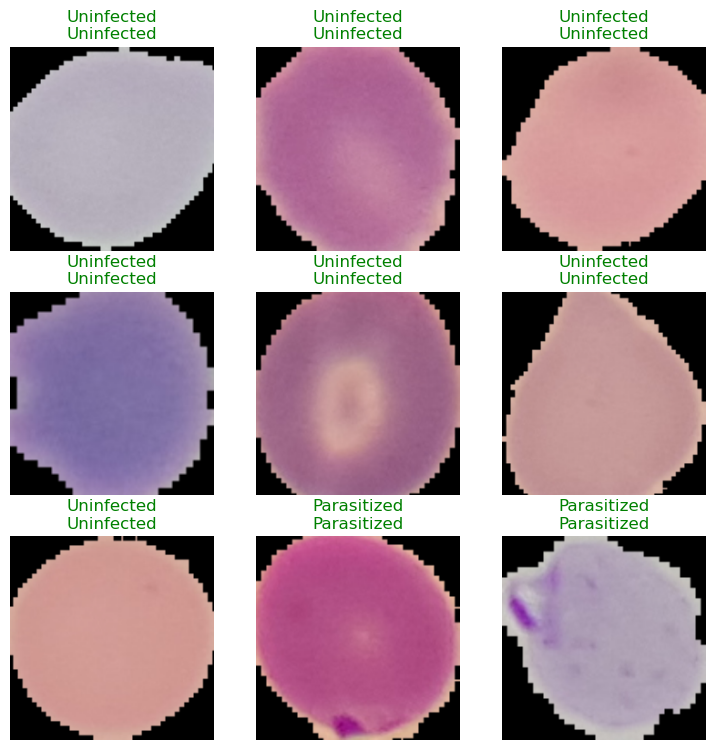

In [21]:
learner.show_results()

### Save model checkpoint

Let's save a checkpoint of our model so we can load it later.

In [14]:
# Save model checkpoint
learner.save("xresnet34-malaria")

Path('models/xresnet34-malaria.pth')

### (Future use) Load saved model

Run this block if you would like to load a model that your previously trained and exported as a checkpoint.

For Colab users, run this first block to upload the checkpoint from your local machine:

In [ ]:
# (Colab only) Upload model from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

fastai expects the model to be in a `models/` directory, so let's move it:

In [ ]:
%%bash

mkdir -p models/
mv xresnet34-malaria.pth models/

Now we can load the saved model:

In [15]:
# Loads `models/xresnet34-malaria.pth` generated by `.save()` 
learner = cnn_learner(data, xresnet34, metrics=[accuracy]).to_fp16()
learner.load("xresnet34-malaria")

## Evaluating model with FiftyOne

While 96% accuracy sounds great, aggregate evaluation metrics are not enough to get a full understanding of the performance of a model and what needs to be done to further improve it.

### Add predictions to FiftyOne dataset

Let's [add our model's predictions](https://voxel51.com/docs/fiftyone/user_guide/using_datasets.html#labels) to our FiftyOne dataset so we can evaluate it in more detail:

In [24]:
import os 
os.getcwd()

'e:\\Bruno\\HIBA\\Ateneos\\Voxel51'

In [26]:
from fiftyone import ViewField as F

def do_inference(learner, dl, dataset, classes, tag):
    # Perform inference
    preds, _ = learner.get_preds(ds_idx=dl.split_idx)
    preds = preds.numpy()

    # Save predictions to FiftyOne dataset
    with fo.ProgressBar() as pb:
        for filepath, scores in zip(pb(dl.items), preds):
            sample = dataset[os.path.join(os.getcwd(),str(filepath))]
            target = np.argmax(scores)
            sample.tags = [tag]
            sample["predictions"] = fo.Classification(
                label=classes[target],
                confidence=scores[target],
                logits=np.log(scores),
            )
            sample.save()

classes = list(data.vocab)

# Run inference on train split
do_inference(learner, data.train, dataset, classes, "train")

# Run inference on validation split
do_inference(learner, data.valid, dataset, classes, "validation")

 100% |█████████████| 22047/22047 [53.1s elapsed, 0s remaining, 407.9 samples/s]      


 100% |███████████████| 5511/5511 [13.3s elapsed, 0s remaining, 416.6 samples/s]      


The predictions are stored in a `predictions` field of our dataset:

In [27]:
print(dataset)

Name:        malaria-cell-images
Media type:  image
Num samples: 27558
Persistent:  True
Tags:        []
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.ImageMetadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)
    predictions:  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Classification)


We've added predictions for both the `train` split:

In [28]:
print(dataset.match_tags("train").first())

<SampleView: {
    'id': '636ebda064617f01d51b05a5',
    'media_type': 'image',
    'filepath': 'e:\\Bruno\\HIBA\\Ateneos\\Voxel51\\datasets\\cell_images\\Parasitized\\C100P61ThinF_IMG_20150918_144104_cell_162.png',
    'tags': ['train'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '636ebda064617f01d51b05a4',
        'tags': [],
        'label': 'Parasitized',
        'confidence': None,
        'logits': None,
    }>,
    'predictions': <Classification: {
        'id': '63723aea64617f01d51c8276',
        'tags': [],
        'label': 'Parasitized',
        'confidence': 0.995718777179718,
        'logits': array([-4.2904136e-03, -5.4535093e+00], dtype=float32),
    }>,
}>


and the `validation` split:

In [29]:
print(dataset.match_tags("validation").first())

<SampleView: {
    'id': '636ebda064617f01d51b05e6',
    'media_type': 'image',
    'filepath': 'e:\\Bruno\\HIBA\\Ateneos\\Voxel51\\datasets\\cell_images\\Parasitized\\C100P61ThinF_IMG_20150918_144823_cell_160.png',
    'tags': ['validation'],
    'metadata': None,
    'ground_truth': <Classification: {
        'id': '636ebda064617f01d51b05d6',
        'tags': [],
        'label': 'Parasitized',
        'confidence': None,
        'logits': None,
    }>,
    'predictions': <Classification: {
        'id': '63723b6a64617f01d51d0b2c',
        'tags': [],
        'label': 'Parasitized',
        'confidence': 0.9969005584716797,
        'logits': array([-3.1042546e-03, -5.7765417e+00], dtype=float32),
    }>,
}>


### Running the evaluation

FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) for evaluating various types of models at the aggregate and sample-level.

In this case, we'll use the [binary classification functionality](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#binary-evaluation) to analyze our model:

In [30]:
# Evaluate the predictions in the `predictions` field with respect to the
# labels in the `ground_truth` field
results = dataset.evaluate_classifications(
    "predictions",
    gt_field="ground_truth",
    eval_key="eval",
    method="binary",
    classes=["Uninfected", "Parasitized"],
)

The method returned a `results` object that provides a number of convenient methods for analyzing our predictions.

### Viewing aggregate metrics

Let's start by printing a classification report:

In [31]:
results.print_report()

              precision    recall  f1-score   support

  Uninfected       0.95      0.98      0.96     13779
 Parasitized       0.98      0.94      0.96     13779

    accuracy                           0.96     27558
   macro avg       0.96      0.96      0.96     27558
weighted avg       0.96      0.96      0.96     27558



Now, how about a confusion matrix:

In [ ]:
%pip install ipywidgets==7.7.2

In [32]:
plot = results.plot_confusion_matrix()
plot.show()

PackageError: The requested operation requires that 'ipywidgets<8,>=7.5' is installed on your machine, but found 'ipywidgets==8.0.1'.

If you think this error is inaccurate, you can set `fiftyone.config.requirement_error_level` to 1 (warning) or 2 (ignore).
See https://voxel51.com/docs/fiftyone/user_guide/config.html for details.

In [ ]:
plot.freeze()  # replaces interactive plot with static image

and finally a precision-recall curve:

In [33]:
plot = results.plot_pr_curve()
plot.show()

PackageError: The requested operation requires that 'ipywidgets<8,>=7.5' is installed on your machine, but found 'ipywidgets==8.0.1'.

If you think this error is inaccurate, you can set `fiftyone.config.requirement_error_level` to 1 (warning) or 2 (ignore).
See https://voxel51.com/docs/fiftyone/user_guide/config.html for details.

In [ ]:
plot.freeze()  # replaces interactive plot with static image

The evaluation method also populated a new `eval` field on our samples that records whether each prediction is a true positive (TP), false positive (FP), false negative (FN), or true negative (TN).

In a few minutes, we'll use this field to interactively explore each type of prediction visually in the App. But for now, let's check the distribution of these labels:

In [34]:
print(dataset.count_values("eval"))

{'FN': 773, 'TP': 13006, 'FP': 324, 'TN': 13455}


### Compute sample hardness with FiftyOne

During training, it is useful to identify samples that are more difficult for a model to learn so that training can be more focused around these hard samples.

Let's use FiftyOne's [hardness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#sample-hardness) to index our dataset by the hardness of our predictions in the `predictions` field.

This method populates a scalar `hardness` field on each of our samples.

In [37]:
import fiftyone.brain as fob

fob.compute_hardness(dataset, "predictions")

Computing hardness...
 100% |█████████████| 27558/27558 [55.2s elapsed, 0s remaining, 475.7 samples/s]      
Hardness computation complete


Now let's use our hardness measure to view the **HARDEST FALSE POSITIVE** samples in the validation split of our dataset.

These are the failure modes of our current model, and this is where we need to dedicate our human time to understand what's going on.

Here are some important questions to ask yourself:

- *Are any of the ground truth annotations on these samples incorrect?* If so, then correcting them will make the biggest positive impact on the ability of our model to separate these two classes
- *Are these predictions actually false positives?* If so, then adding more examples that are visually similar to these to your training dataset will also improve your model


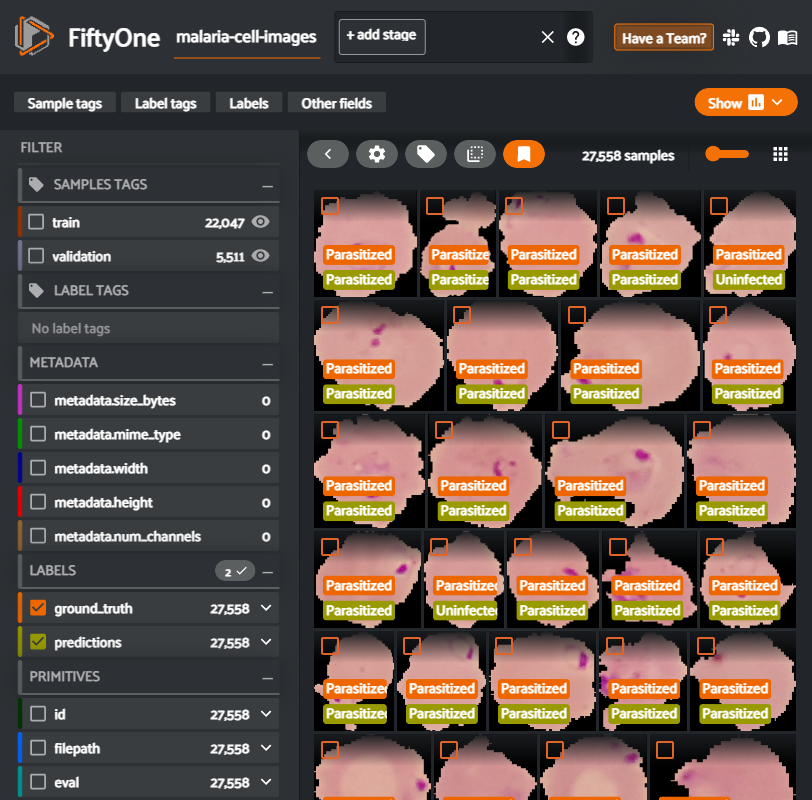


Could not connect session, trying again in 10 seconds

Could not connect session, trying again in 10 seconds




In [44]:
# Show the HARDEST FALSE POSITIVES on validation split
session = fo.launch_app(dataset)
session.view = (
    dataset
    .match_tags("validation")
    .match(F("eval") == "FP")
    .sort_by("hardness", reverse=True)
)

Viewing the **HARDEST FALSE NEGATIVE** samples from the validation split also gives insights into what fools our model into wrongly believing that a sample is uninfected.

Or, are the ground truth annotations incorrect? The same questions from the previous section apply. Finding mistakes in your ground truth data is equally as important as identifying the true failure modes of your model.

In [ ]:
# Show the HARDEST FALSE NEGATIVES on validation split
session.view = (
    dataset
    .match_tags("validation")
    .match(F("eval") == "FN")
    .sort_by("hardness", reverse=True)
)

### Finding ground truth mistakes using FiftyOne

Even well-known datasets can have [significant ground truth mistakes](https://towardsdatascience.com/i-performed-error-analysis-on-open-images-and-now-i-have-trust-issues-89080e03ba09).

Fortunately, FiftyOne provides a [mistakenness method](https://voxel51.com/docs/fiftyone/user_guide/brain.html#label-mistakes) that can automatically identify the potential ground truth mistakes in your dataset.

The cell below runs the mistakenness method using the predictions in the `predictions` field of the dataset as a point of reference to find the most likely mistakes in the `ground_truth` annotations: 

In [ ]:
import fiftyone.brain as fob

fob.compute_mistakenness(dataset, "predictions", label_field="ground_truth")

We can easily update our view in the App to show, for example, the most likely annotation mistakes in the `train` split of our dataset. In the cell below, we have only selected the `eval` field in the App so that we see the samples together with their TP/FP/FN/TN evaluation labels.

I'm not a medical imaging expert, but to my untrained eye, the examples below suggest two concrete opportunities for improvement to our training dataset:

- Many of the false negatives below seem to be *true negatives*. These ground truth annotations likely need another annotation pass to correct for errors
- Many of the remaining false negatives seem to be cases where the infection is near the **boundary** of the cell images. Augmenting the training dataset with more `Parasitized` examples of this kind would likely improve the performance of our model!

In [ ]:
# Show the most likely ANNOTATION MISTAKES on the train split
session.view = (
    dataset
    .match_tags("train")
    .sort_by("mistakenness", reverse=True)
)

In [ ]:
session.freeze()

## Summary

In this notebook, we covered loading a dataset into FiftyOne, fine-tuning a fastai model on it, and analyzing the failure modes of the model using FiftyOne.

**So, what's the takeaway?**

The loss function of your training loop doesn't tell the whole story of your model; it's critical to study the failure modes of your model so you can take the right actions to improve them.

In this notebook, we covered two types of actions:

- Finding potential annotation mistakes and exporting the problem samples for review/reannotation
- Identifying scenarios that require additional training samples

In upcoming tutorials, we'll cover how FiftyOne can enable you to **automate** both of these actions. Stay tuned!

## Appendix B: fastai export

### Export a model

Exporting a fastai model as an encapsulated pickle file is also easy:

In [36]:
# Export your model as a standalone `pkl` file
learner.export("models/xresnet34-malaria.pkl")

In [ ]:
# (Colab only) Download model to your machine
from google.colab import files

files.download("models/xresnet34-malaria.pkl") 

### Loading an exported model

Run the code block below if you'd like to load an existing fastai model and run inference on new data with it in colab:

In [ ]:
# (Colab only) Upload model from your machine
from google.colab import files

uploaded = files.upload()
for filename in uploaded.keys():
    print("Uploaded '%s'" % filename)

In [ ]:
%%bash

mkdir -p models/
mv xresnet34-malaria.pkl models/

In [ ]:
# Load exported model
learner = load_learner("models/xresnet34-malaria.pkl")

In [ ]:
# Perform test inference

#IMAGE_PATH = "cell_images/Uninfected/C145P106ThinF_IMG_20151016_154844_cell_62.png"
IMAGE_PATH = "cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png"

print(learner.predict(IMAGE_PATH))